# Linear Regression Analysis
---
**Research question**: "How many friends does a person have based on how much time they spend alone, post online, and whether they go outside and attend social events?"

I want to estimate how many friends a person may have based on time spent alone, how often they post online, and whether they attend social events when going outside (interaction).

$y = Friend\ Circle\ Size$

$\beta_0 = Intercept$

$\beta_1 = Time\ spent\ alone$

$\beta_2 = Post\ frequency$

$\beta_3 = Going\ outside$

$\beta_4 = Social\ event\ attendance$

$$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_2*\beta_3$$

**NOTE:**
- Each survey item scale may be normally distributed, but when combined may form a non-normally distributed dataset.
    - We care about the error term being normally distributed ($\epsilon \sim N(0, \sigma^2))$.
    - We can standardize the survey scales to be proportions: $\frac{x}{max(x)}$

In [154]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
from enum import Enum
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import bootstrap
import seaborn as sns

In [155]:
# Receive dataframe from Preprocessing
%store -r pre_df

# Converge personality into one column and remove the other columns.
# 1 = extrovert; 0 = introvert
pre_df["Personality"] = pre_df["Personality_Extrovert"]
pre_df = pre_df.drop(["Personality_Extrovert", "Personality_Introvert"], axis="columns")

# Save predictors array for re-use
predictors = ["Time_spent_Alone", "Post_frequency", "Going_outside", "Social_event_attendance"]

## Transform Data
The data is not normally distributed and will need to be transformed in some way. We can scale predictors as proportions $\frac{x}{max(x)}$, as each predictor has a different survey scale range (0-5, 0-7, 0-11, etc). Or we can apply natural log or square root operations to each predictor.

In [156]:
# Apply transformation to each variable
def transform(dataframe):
    for column in predictors:
        # Get proportion of responses.
        dataframe[column] = dataframe[column] / max(pre_df[column])

        # Apply log transform
        # dataframe[column] = np.where(dataframe[column] > 0, np.log(dataframe[column]), np.nan)

        # Apply square root transformation
        # dataframe[column] = np.sqrt(dataframe[column])

In [157]:
train_df = pre_df.sample(frac=0.8, random_state=1863)
transform(train_df)
test_df = pre_df.drop(train_df.index)
transform(test_df)

### Observe Frequency Distribution

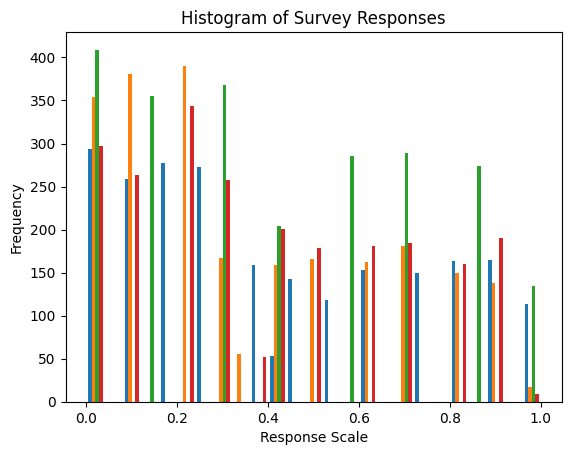

In [158]:
predictors = train_df[predictors]

plt.hist(predictors, bins=25)
plt.title("Histogram of Survey Responses")
plt.xlabel("Response Scale")
plt.ylabel("Frequency")
plt.show()

## Manual Linear Regression

In [159]:
# See: https://ayoakin.medium.com/linear-regression-from-scratch-using-matrices-991df6e28f62

'''
X = train_df[predictors].copy()
X["Going_outside:Social_event_attendance"] = train_df["Going_outside"] * train_df["Social_event_attendance"]
y = train_df[["Friends_circle_size"]].copy()

# Append column of 1s
X["Intercept"] = 1

# Transpose
X_T = X.T

# Calculate beta 1 using matrix form
B = np.linalg.inv(X_T @ X) @ (X_T @ y)

B.index = X.columns

# Compute predictions of y-hat using beta 1
predictions = X @ B

# Calculate Sum of Squares
SSR = ((y - predictions) ** 2).sum()
# Calculate Sum of Squares total
SST = ((y - y.mean()) ** 2).sum()
# Calculate R^2
R2 = 1 - (SSR / SST)

residuals = y - predictions

print("\nR-Squared: {}".format(R2.iloc[0]))
B, residuals.head()
'''

'\nX = train_df[predictors].copy()\nX["Going_outside:Social_event_attendance"] = train_df["Going_outside"] * train_df["Social_event_attendance"]\ny = train_df[["Friends_circle_size"]].copy()\n\n# Append column of 1s\nX["Intercept"] = 1\n\n# Transpose\nX_T = X.T\n\n# Calculate beta 1 using matrix form\nB = np.linalg.inv(X_T @ X) @ (X_T @ y)\n\nB.index = X.columns\n\n# Compute predictions of y-hat using beta 1\npredictions = X @ B\n\n# Calculate Sum of Squares\nSSR = ((y - predictions) ** 2).sum()\n# Calculate Sum of Squares total\nSST = ((y - y.mean()) ** 2).sum()\n# Calculate R^2\nR2 = 1 - (SSR / SST)\n\nresiduals = y - predictions\n\nprint("\nR-Squared: {}".format(R2.iloc[0]))\nB, residuals.head()\n'

## Linear Regression using `statsmodels`

In [160]:
transformed_df = train_df.copy()[[
    "Time_spent_Alone",
    "Post_frequency",
    "Going_outside",
    "Social_event_attendance",
    "Friends_circle_size",
]]

model = ols(
    formula='Friends_circle_size ~ Time_spent_Alone + Post_frequency + Going_outside*Social_event_attendance',
    data=transformed_df
).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Friends_circle_size   R-squared:                       0.635
Model:                             OLS   Adj. R-squared:                  0.634
Method:                  Least Squares   F-statistic:                     804.5
Date:                 Mon, 14 Jul 2025   Prob (F-statistic):               0.00
Time:                         18:50:07   Log-Likelihood:                -5471.3
No. Observations:                 2320   AIC:                         1.095e+04
Df Residuals:                     2314   BIC:                         1.099e+04
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 3.3430      0.267     12.515      0.000       2.819       3.867
Time_spent_Alone                         -2.7427      0.281     -9.759      0.000      -3.294      -2.192
Post_frequency                            2.1739      0.316      6.878      0.000       1.554       2.794
Going_outside                             3.8564      0.467      8.262      0.000       2.941       4.772
Social_event_attendance                   4.7548      0.538      8.837      0.000       3.700       5.810
Going_outside:Social_event_attendance    -1.2265      0.892     -1.375      0.169      -2.976       0.523
==============================================================================
Omnibus:                       33.608   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.649
Skew:                           0.248   Prob(JB):                     1.34e-07
Kurtosis:                       2.715   Cond. No.                         26.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Predict Using Test Dataframe

In [161]:
test_df_prediction = test_df.copy()[[
    "Time_spent_Alone",
    "Post_frequency",
    "Going_outside",
    "Social_event_attendance",
    "Friends_circle_size",
    "Personality"
]]

# Combine scaled test data with predictions
test_df_prediction['Predicted'] = model.predict(test_df_prediction)

## (Optional) Switch Personality
We can switch the personality type of the observations to see the differences in the groups. Default setting will show data points from both introverts and extroverts. This is necessary as there are known outliers that may influence the inference of the model.

In [162]:
class Personality(Enum):
    introvert = (0, "Introvert")
    extrovert = (1, "Extrovert")

def switch_personality(personality: Personality | None = None):
    if personality:
        return test_df_prediction[test_df_prediction["Personality"] == personality.value[0]]
    else:
        return test_df_prediction

test_df_prediction = switch_personality()

## Plot regression model

### Decision (Tree) Linear Regression
Plot each predictor against the predicted friend circle size and compare against the actual data points. Some calibration is needed.

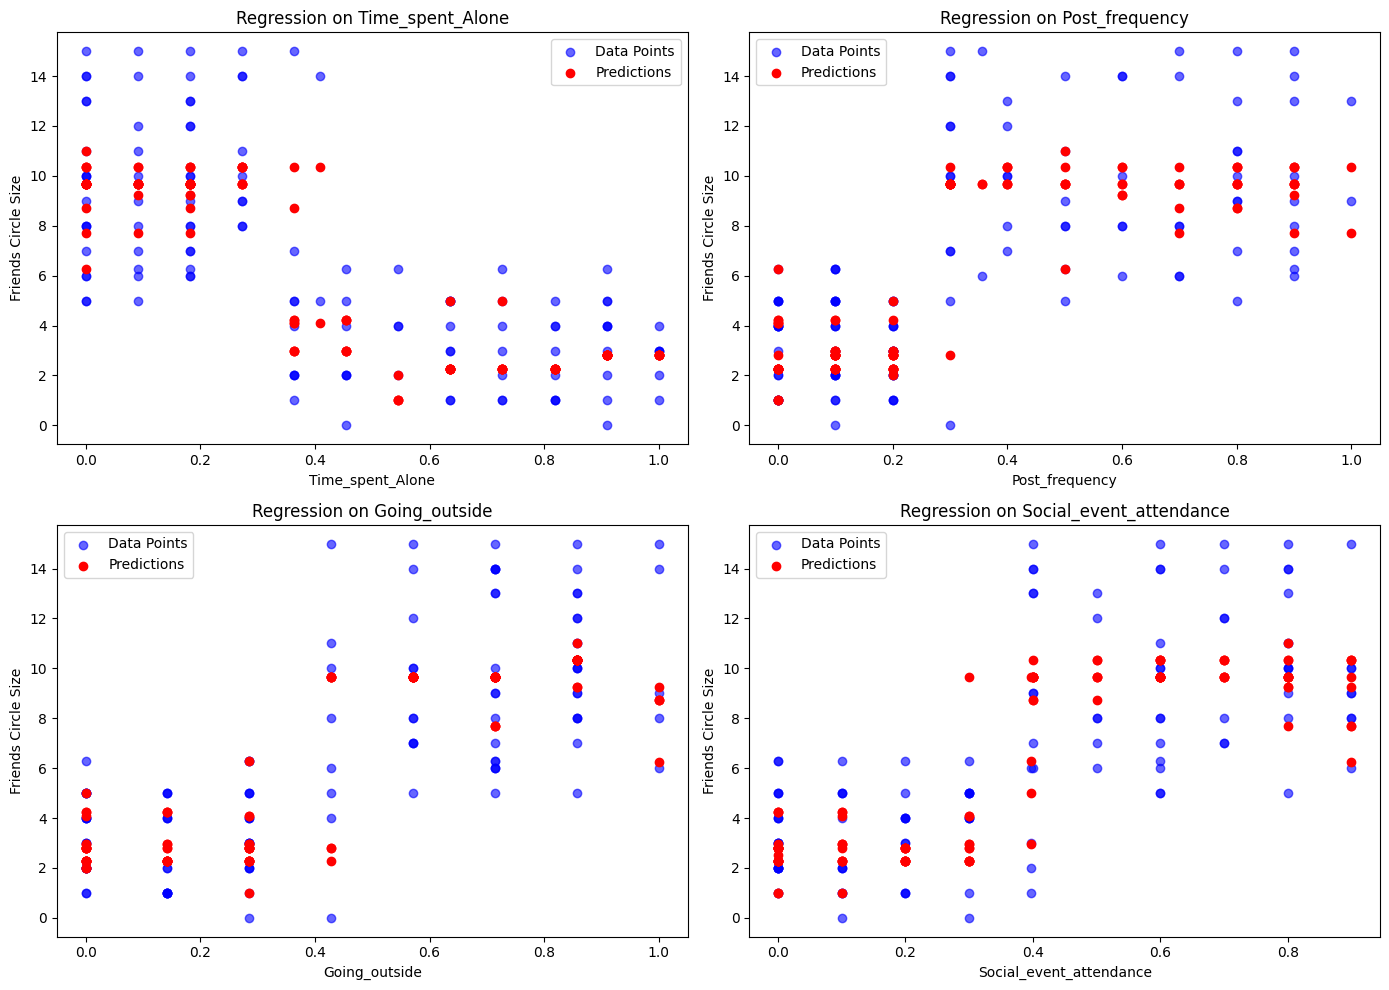

In [163]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, predictor in enumerate(predictors):
    ax = axs[i]
    X = test_df_prediction.drop('Friends_circle_size', axis=1)
    y = test_df_prediction['Friends_circle_size']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1863)

    # Create a DecisionTreeRegressor instance with maximum depth of 5
    dt_model = DecisionTreeRegressor(max_depth=5).fit(X_train, y_train)

    y_pred = dt_model.predict(X_test)

    ax.scatter(
        x=X_test[predictor],
        y=y_test,
        color="blue",
        alpha=0.6,
        label="Data Points"
    )
    ax.scatter(X_test[predictor], y_pred, color='red', label='Predictions')

    ax.set_title(f'Regression on {predictor}')
    ax.set_xlabel(predictor)
    ax.set_ylabel('Friends Circle Size')
    ax.legend()
plt.tight_layout()
plt.show()

### OLS Linear Regression with CI and PI
Plot OLS linear regression for each predictor against friend circle size with confidence and predictor intervals.

**NOTE:** Because each predictor influences each other when plotting data points, a linear space of data between the min and max of each predictor was needed to be generated. Additionally, each of the other predictors need to be held constant. This means that this test data is synthetic, but is used for model visualization and is not integrated into the test and train samples.

                             OLS Regression Results                            
Dep. Variable:     Friends_circle_size   R-squared:                       0.635
Model:                             OLS   Adj. R-squared:                  0.634
Method:                  Least Squares   F-statistic:                     804.5
Date:                 Mon, 14 Jul 2025   Prob (F-statistic):               0.00
Time:                         18:58:21   Log-Likelihood:                -5471.3
No. Observations:                 2320   AIC:                         1.095e+04
Df Residuals:                     2314   BIC:                         1.099e+04
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

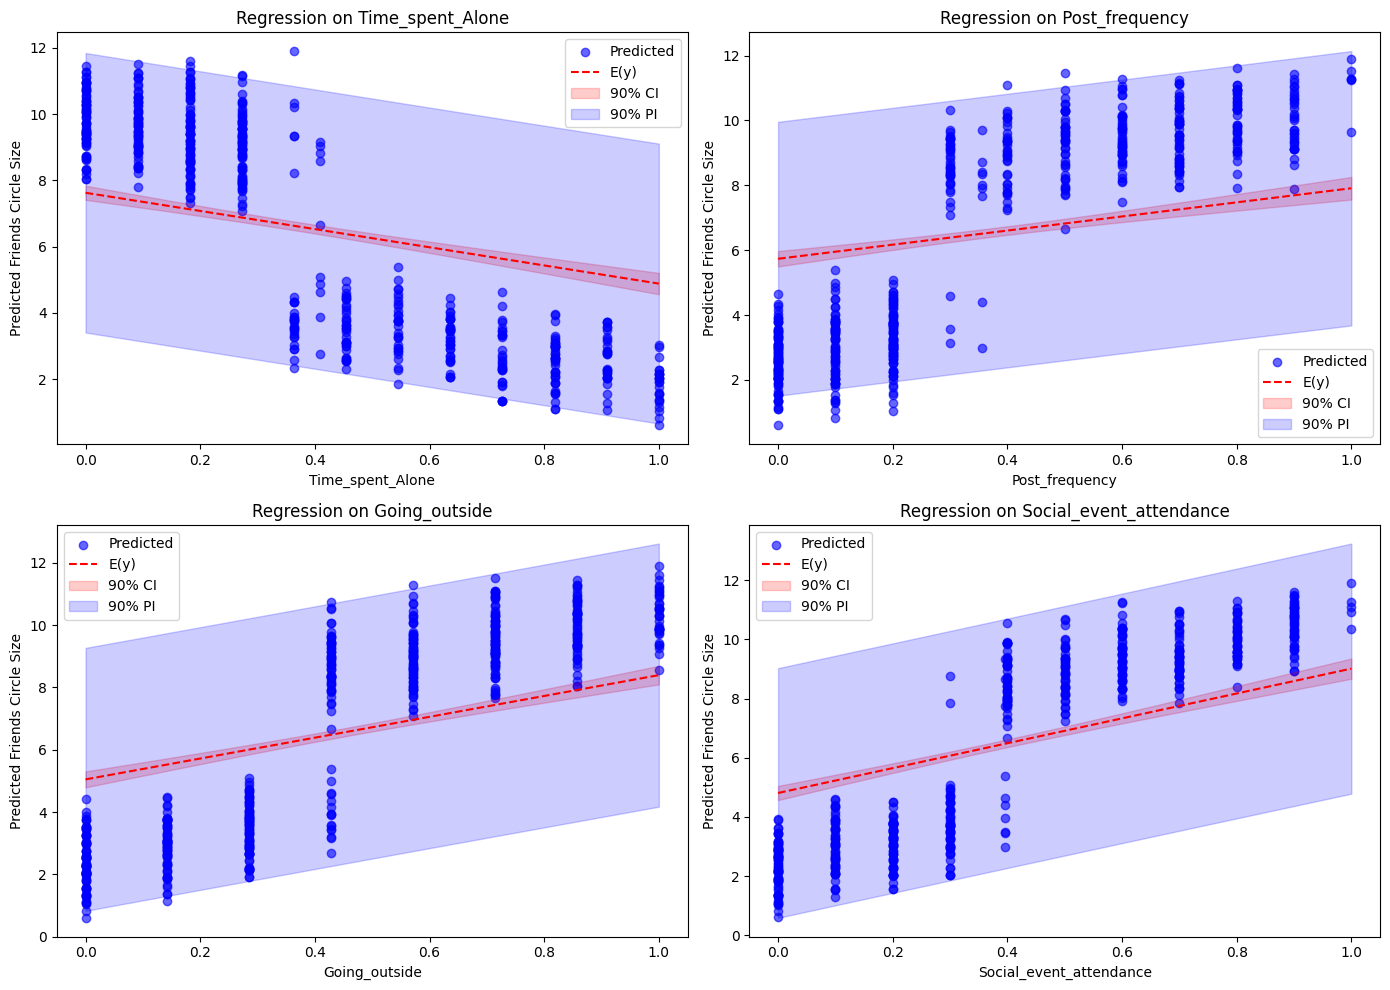

In [181]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

print(model.summary())

for i, predictor in enumerate(predictors):
    ax = axs[i]

    # Isolate effects of each predictor and hold other predictors constant (at mean).
    # Generate synthetic data within bounds of predictor; used for testing model
    x_vals = np.linspace(test_df_prediction[predictor].min(), test_df_prediction[predictor].max(), 100)

    # Create a DataFrame with mean values for other predictors
    fixed_data = pd.DataFrame({
        col: [test_df_prediction[col].mean()] * len(x_vals) if col != predictor else x_vals
        for col in predictors
    })
    # fixed_data = fixed_data[predictors]  # Ensure column order

    pred = model.get_prediction(fixed_data)
    pred_summary = pred.summary_frame(alpha=0.10)

    # Plot points
    ax.scatter(
        test_df_prediction[predictor],
        test_df_prediction["Predicted"],
        color="blue",
        alpha=0.6,
        label="Predicted"
    )

    # Regression Line
    ax.plot(
        x_vals,
        pred_summary['mean'],
        color='red',
        label='E(y)',
        linestyle='--'
    )

    # Confidence interval
    ax.fill_between(
        x_vals,
        pred_summary['mean_ci_lower'],
        pred_summary['mean_ci_upper'],
        color='red',
        alpha=0.2,
        label='90% CI'
    )

    # Prediction interval
    ax.fill_between(
        x_vals,
        pred_summary['obs_ci_lower'],
        pred_summary['obs_ci_upper'],
        color='blue',
        alpha=0.2,
        label='90% PI'
    )

    ax.set_title(f'Regression on {predictor}')
    ax.set_xlabel(predictor)
    ax.set_ylabel('Predicted Friends Circle Size')
    ax.legend()

plt.tight_layout()
plt.show()

## Segmented Linear Regression

### Find Optimal Breakpoints for Each Predictor

In [ ]:
import statsmodels.api as sm

def find_optimal_breakpoint(x, y, min_points=10):
    """
    Try all possible split points, and return the one that minimizes total RSS (residual sum of squares).
    """
    # Sort x in a logical order.
    x_sorted = x.sort_values().reset_index(drop=True)
    possible_splits = x_sorted[min_points:-min_points]

    best_rss = float('inf')
    best_break = None

    for split in possible_splits:
        # Split the data:
        # Left segment: x[mask], y[mask]
        # Right segment: x[~mask], y[~mask]
        mask = x < split
        if mask.sum() < min_points or (~mask).sum() < min_points:
            continue
        
        # Left segment
        model_left = sm.OLS(y[mask], sm.add_constant(x[mask])).fit()
        rss_left = np.sum(model_left.resid ** 2)

        # Right segment
        model_right = sm.OLS(y[~mask], sm.add_constant(x[~mask])).fit()
        rss_right = np.sum(model_right.resid ** 2)

        # Get the smallest residual sum of squares
        total_rss = rss_left + rss_right

        if total_rss < best_rss:
            best_rss = total_rss
            best_break = split

    return best_break

# Create empty dataframe with predictors as columns and first row filled with NA
breakpoints = pd.DataFrame(np.nan, columns=predictors.columns, index=[1])

# Fill first row with optimal breakpoints.
for predictor in predictors:
    breakpoints[predictor] = find_optimal_breakpoint(test_df_prediction[predictor], test_df_prediction["Predicted"])

breakpoints

,Time_spent_Alone,Post_frequency,Going_outside,Social_event_attendance
1,0.363636,0.3,0.428571,0.4


### Plot Segmented Regressions with CI & PI

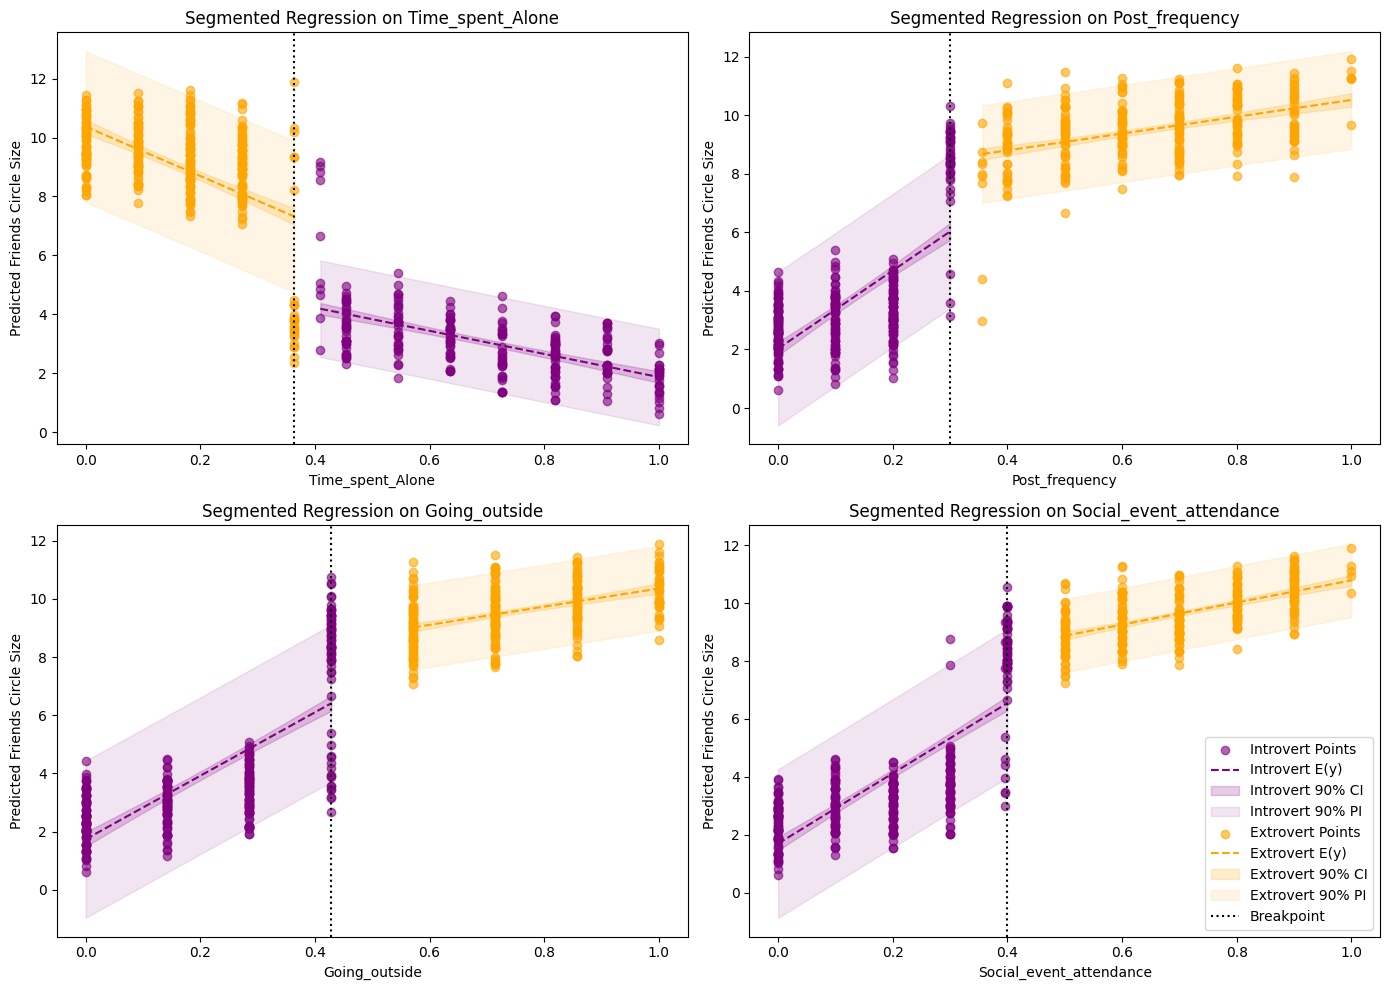

In [219]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

segments = {
    1: {
        "label": Personality.extrovert.value[1],
        "color": "orange"
    },
    0: {
        "label": Personality.introvert.value[1],
        "color": "purple"
    }
}

for i, predictor in enumerate(predictors):
    ax = axs[i]
    bp = breakpoints[predictor][1]

    # Split dataset at breakpoint
    low_mask = test_df_prediction[predictor] <= bp
    high_mask = test_df_prediction[predictor] > bp

    for mask in [low_mask, high_mask]:
        segment_data = test_df_prediction[mask]
        X = segment_data[[predictor]].copy()
        X = sm.add_constant(X)
        y = segment_data["Predicted"]

        model_seg = sm.OLS(y, X).fit()

        # Generate x values in this segment range
        x_vals = np.linspace(X[predictor].min(), X[predictor].max(), 100)
        X_plot = pd.DataFrame({predictor: x_vals})
        X_plot = sm.add_constant(X_plot)

        pred = model_seg.get_prediction(X_plot)
        pred_summary = pred.summary_frame(alpha=0.10)

        # Determine the most common personality type, labeling and coloring as assigned
        personality = segment_data["Personality"].mode()[0]

        # Plot actual points in this segment
        ax.scatter(
            segment_data[predictor],
            segment_data["Predicted"],
            alpha=0.6,
            color=segments[personality]["color"],
            label=f"{segments[personality]['label']} Points"
        )

        # Plot regression line
        ax.plot(
            x_vals,
            pred_summary['mean'],
            color=segments[personality]["color"],
            linestyle='--',
            label=f'{segments[personality]['label']} E(y)'
        )

        # Confidence interval
        ax.fill_between(
            x_vals,
            pred_summary['mean_ci_lower'],
            pred_summary['mean_ci_upper'],
            color=segments[personality]["color"],
            alpha=0.2,
            label=f'{segments[personality]['label']} 90% CI'
        )

        # Prediction interval
        ax.fill_between(
            x_vals,
            pred_summary['obs_ci_lower'],
            pred_summary['obs_ci_upper'],
            color=segments[personality]["color"],
            alpha=0.1,
            label=f'{segments[personality]['label']} 90% PI'
        )

    ax.set_title(f'Segmented Regression on {predictor}')
    ax.set_xlabel(predictor)
    ax.set_ylabel('Predicted Friends Circle Size')
    ax.axvline(bp, color='black', linestyle=':', label='Breakpoint')

plt.legend()
plt.tight_layout()
plt.show()

### Determine Fitness of Residuals

Residual standard error: 2.7256954326475746


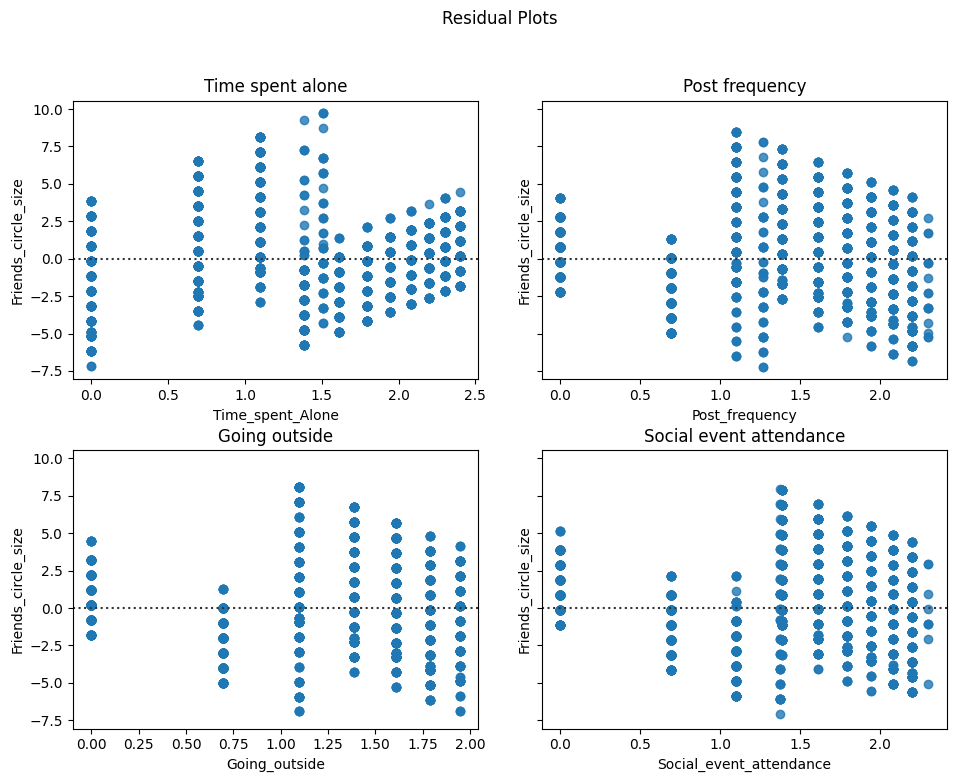

In [ ]:
residuals = model.resid

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
fig.suptitle("Residual Plots")
fig.tight_layout(pad=3.0)

plots_info = [
    {
        "name": "Time_spent_Alone",
        "title": "Time spent alone",
        "axes": (0, 0)
    },
    {
        "name": "Post_frequency",
        "title": "Post frequency",
        "axes": (0, 1)
    },
    {
        "name": "Going_outside",
        "title": "Going outside",
        "axes": (1, 0)
    },
    {
        "name": "Social_event_attendance",
        "title": "Social event attendance",
        "axes": (1, 1)
    }
]

print("Residual standard error: {}".format(np.std(residuals)))

for plot in plots_info:
    y_axis = plot["axes"][0]
    x_axis = plot["axes"][1]
    position = axes[y_axis, x_axis]
    sns.residplot(transformed_df, x=plot["name"], y="Friends_circle_size", ax=position)
    position.set_title(plot["title"])


## Prediction

In [ ]:
B = model.params
print(B)

time_alone = B.iloc[1]
post_freq = B.iloc[2]
outside = B.iloc[3]
events = B.iloc[4]
outside_event_attendance = B.iloc[5]

# Regression variables were log transformed
y = time_alone*np.log(1) + post_freq*np.log(9) + + outside*np.log(9) + events*np.log(9) + outside_event_attendance*np.log(1)
y

Intercept                                3.500542
Time_spent_Alone                        -0.960035
Post_frequency                           0.627741
Going_outside                            1.184281
Social_event_attendance                  0.955080
Going_outside:Social_event_attendance    0.700362
dtype: float64


np.float64(6.079943812320706)